In [58]:
import numpy as np
import random
from bs4 import BeautifulSoup
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
import matplotlib.pyplot as plt
import networkx as nx
from colour import Color
import copy
from collections import Counter

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv

import json

import seaborn as sns

np.random.seed(42)
random.seed(42)
import pm4py

from collections import Counter
import subprocess

In [59]:
from pm4py.objects.log.importer.xes import importer as xes_importer
log_application = xes_importer.apply('BPI Challenge 2017.xes')

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [60]:
# A_complete is always preceeded by "W_call after offers"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "A_Complete" in pos["concept:name"]:
            if "W_Call after offers" not in trace[pos_index-1]["concept:name"]:
                for e in trace[pos_index-5:pos_index+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [61]:
# "W_call after offers" has always "A_complete"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "W_call after offers" in pos["concept:name"]:
            index_inner = pos_index+1
            while trace[index_inner]["concept:name"] == "W_call after offers":
                index_inner += 1
            if "A_complete" not in trace[index_inner]["concept:name"]:
                for e in trace[index_inner-5:index_inner+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [62]:
# A_Incomplete is always surrounded by "W_Call incomplete files"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "A_Incomplete" in pos["concept:name"]:
            if "W_Call incomplete files" not in trace[pos_index-1]["concept:name"] and "W_Call incomplete files" not in trace[pos_index+1]["concept:name"]:
                for e in trace[pos_index-5:pos_index+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [63]:
#Create offer is always followed by "Created"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "Create Offer" in pos["concept:name"]:
            if "Created" not in trace[pos_index+1]["concept:name"]:
                print("not followed")

In [64]:
# number of calls
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "Create Offer" in pos["concept:name"]:
            if "Created" not in trace[pos_index+1]["concept:name"]:
                print("not followed")

In [65]:
def contains(trace, element):
    for event in trace:
        if event['concept:name']==element:
            return True

In [66]:
log = copy.deepcopy(log_application)
log_before = pm4py.filter_time_range(log, "2011-03-09 00:00:00", "2016-06-30 23:59:59", mode='traces_contained')
log_after = pm4py.filter_time_range(log, "2016-08-01 00:00:00", "2018-03-09 00:00:00", mode='traces_contained')
print(np.shape(log))
print(np.shape(log_before))
print(np.shape(log_after))

(31509,)
(12207,)
(14164,)


In [67]:
def filter_log(log):
    perc = 2/len(log)
    return pm4py.filter_variants_by_coverage_percentage(log, perc)

filtered_log_before = filter_log(log_before)
filtered_log_after = filter_log(log_after)

6156 7636
10 12
{'Action': 'Obtained', 'org:resource': 'User_18', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_313669609', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 4, 11, 10, 49, 19, 466000, tzinfo=datetime.timezone.utc)}
{'Action': 'Released', 'org:resource': 'User_18', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_567241498', 'lifecycle:transition': 'suspend', 'time:timestamp': datetime.datetime(2016, 4, 11, 15, 11, 51, 55000, tzinfo=datetime.timezone.utc)}
[{'Action': 'Obtained', 'org:resource': 'User_18', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_313669609', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 4, 11, 10, 49, 19, 466000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_18', 'concept:name': 'A_Complete', 'EventOrigin': 'Application', 'EventID': 'ApplState_

13 15
{'Action': 'Obtained', 'org:resource': 'User_49', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_1703092435', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 2, 1, 16, 2, 4, 705000, tzinfo=datetime.timezone.utc)}
{'Action': 'Released', 'org:resource': 'User_1', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_838362913', 'lifecycle:transition': 'suspend', 'time:timestamp': datetime.datetime(2016, 2, 1, 23, 0, 29, 225000, tzinfo=datetime.timezone.utc)}
[{'Action': 'Obtained', 'org:resource': 'User_49', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_1703092435', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 2, 1, 16, 2, 4, 705000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_49', 'concept:name': 'A_Complete', 'EventOrigin': 'Application', 'EventID': 'ApplState_1760347525', 'li

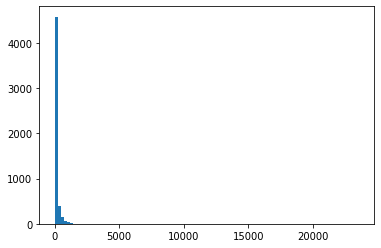

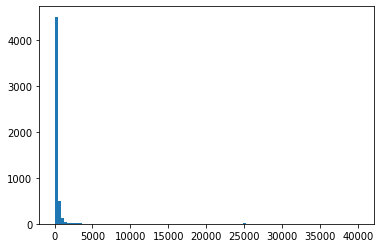

8
12300.278
4700.303
W_Call after offers


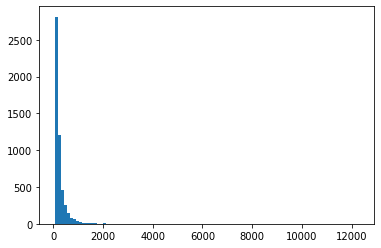

W_Call incomplete files


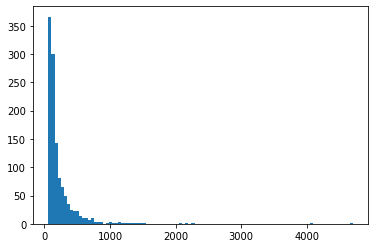

13 15
{'Action': 'Obtained', 'org:resource': 'User_96', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_272763374', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 10, 27, 14, 34, 50, 269000, tzinfo=datetime.timezone.utc)}
{'Action': 'Released', 'org:resource': 'User_96', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_530300024', 'lifecycle:transition': 'suspend', 'time:timestamp': datetime.datetime(2016, 10, 27, 17, 24, 39, 3000, tzinfo=datetime.timezone.utc)}
[{'Action': 'Obtained', 'org:resource': 'User_96', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_272763374', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 10, 27, 14, 34, 50, 269000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_96', 'concept:name': 'A_Complete', 'EventOrigin': 'Application', 'EventID': 'ApplState_61468030

23 25
{'Action': 'Obtained', 'org:resource': 'User_100', 'concept:name': 'W_Call incomplete files', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_579422813', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 8, 17, 14, 43, 58, 935000, tzinfo=datetime.timezone.utc)}
{'Action': 'Released', 'org:resource': 'User_1', 'concept:name': 'W_Call incomplete files', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_1251125448', 'lifecycle:transition': 'suspend', 'time:timestamp': datetime.datetime(2016, 8, 17, 22, 0, 4, 325000, tzinfo=datetime.timezone.utc)}
[{'Action': 'Obtained', 'org:resource': 'User_100', 'concept:name': 'W_Call incomplete files', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_579422813', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 8, 17, 14, 43, 58, 935000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_100', 'concept:name': 'A_Incomplete', 'EventOrigin': 'Application', 'EventID': 'Appl

10 12
{'Action': 'Obtained', 'org:resource': 'User_46', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_1696509761', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 9, 15, 19, 11, 58, 242000, tzinfo=datetime.timezone.utc)}
{'Action': 'Released', 'org:resource': 'User_1', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_1548675384', 'lifecycle:transition': 'suspend', 'time:timestamp': datetime.datetime(2016, 9, 15, 22, 0, 0, 708000, tzinfo=datetime.timezone.utc)}
[{'Action': 'Obtained', 'org:resource': 'User_46', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_1696509761', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 9, 15, 19, 11, 58, 242000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_46', 'concept:name': 'A_Complete', 'EventOrigin': 'Application', 'EventID': 'ApplState_629886578

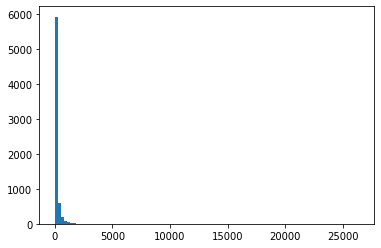

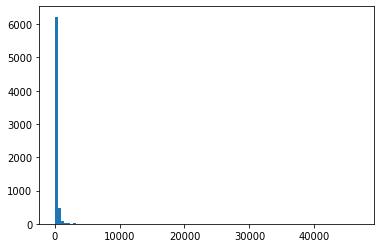

8
12527.361
5056.641
W_Call after offers


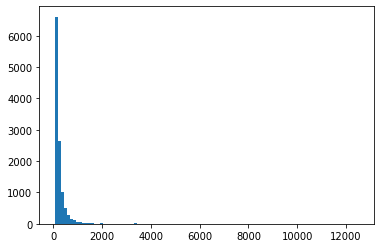

W_Call incomplete files


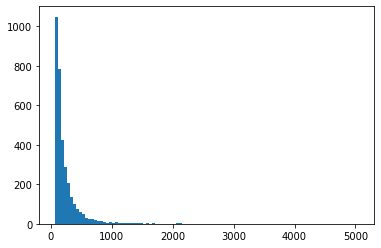

5269 6900


In [68]:
TIME_DIFF = 0
MIN_SPEAKING_TIME = 60
SPEAK_THRESHOLD = 600
DAY_DIFFERENCE = 28
durations = {}
def construct_log(log):
    terminal_states = ['A_Cancelled COMPANY', 'A_Cancelled CUSTOMER', 'A_Pending']#, 'A_Denied']
    to_merge = ['W_Call incomplete files', 'W_Call after offers', 'W_Complete application', 'W_Validate application']
    log_activities = []
    for trace in log:
        current_trace = [trace[0]]
        for i in range(1,len(trace)):
            pos = trace[i]
            if "W_Call" in trace[i]['concept:name']:
                # search for closing event
                if pos['lifecycle:transition'] in ["start", "resume"]:
                    for inner_index in range(i+1, len(trace)):
                        inner_pos = trace[inner_index]
                        if pos['concept:name'] == inner_pos['concept:name']:
                            if inner_pos['lifecycle:transition'] in ["suspend", "complete"]:                 
                                duration = (inner_pos['time:timestamp']-pos['time:timestamp']).total_seconds()
                                if duration > MIN_SPEAKING_TIME:
                                    if duration > 10000:
                                        print(i, inner_index)
                                        print(pos)
                                        print(inner_pos)
                                        print(trace[i: inner_index+1])
                                        print("#########")
                                    if pos['concept:name'] in current_trace[-1]["concept:name"]:
                                        current_trace[-1]["duration"] += duration
                                    else:
                                        current_trace.append(pos)
                                        current_trace[-1]['duration'] = duration
                                    if current_trace[-1]["duration"] < SPEAK_THRESHOLD:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" SHORT"
                                    elif current_trace[-1]["duration"] < 14400:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" LONG"
                                    else:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" SUPER LONG"
                                    if pos['concept:name'] not in durations:
                                        durations[trace[i]['concept:name']] = []
                                    durations[trace[i]['concept:name']].append(duration)
                            break
            if "W_" in trace[i]['concept:name']:
                continue
            if trace[i]['concept:name'] in ["A_Created", "A_Complete", "A_Incomplete"]:
                continue
            if trace[i]['concept:name'] == "A_Cancelled":
                current_trace.append(pos)
                if (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).days > DAY_DIFFERENCE:
                    current_trace[-1]['concept:name'] = "TIMEOUT"
                else:
                    current_trace[-1]['concept:name'] += " CUSTOMER"
                continue
            if "O_Created" == trace[i]['concept:name']:
                continue # merge create and created
            """
            if "A_Cancelled" == trace[i]['concept:name']:
                current_trace.append(pos)
                if (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).days >28:
                    current_trace[-1]['concept:name'] = current_trace[-1]['concept:name']+" AUTO"
                else:
                    current_trace[-1]['concept:name'] = current_trace[-1]['concept:name']+" USER"
            """
            if trace[i]['concept:name'] in terminal_states:
                current_trace.append(pos)
            else:
                if trace[i]['concept:name'] in to_merge and trace[i]['concept:name'] == trace[i-1]['concept:name']:
                    continue
                elif (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).total_seconds()>TIME_DIFF:
                    current_trace.append(pos)
        if "A_Pending" in [pos['concept:name'] for pos in current_trace]:
            if "O_Cancelled" in [pos['concept:name'] for pos in current_trace]:
                for pos1 in current_trace:
                    if 'O_Cancelled' in pos1['concept:name']:
                        current_trace.remove(pos1)
        intersection = [i for i in trace if i['concept:name'] in terminal_states]
        for state in terminal_states:
            indices = [i for i, x in enumerate(current_trace) if x['concept:name'] == state]
            if indices:
                current_trace = current_trace[:indices[0]+1]
        if intersection:
            log_activities.append(current_trace)
            
    duration_incomplete_list = []
    duration_offer_list = []
    for trace in log_activities:
        duration_incomplete = 0
        duration_offer = 0
        for pos in trace:
            if "W_Call incomplete files" in pos["concept:name"]:
                duration_incomplete += pos["duration"]
            if "W_Call after offers" in pos["concept:name"]:
                duration_offer += pos["duration"]
        duration_incomplete_list.append(duration_incomplete)
        duration_offer_list.append(duration_offer)
    plt.hist(duration_incomplete_list,100)
    plt.show()
    plt.hist(duration_offer_list,100)
    plt.show()
    
    print(len(durations))
    after_offers = durations["W_Call after offers SHORT"]+durations["W_Call after offers LONG"]
    incomplete_files = durations["W_Call incomplete files SHORT"]+durations["W_Call incomplete files LONG"]
    print(max(after_offers)) 
    print(max(incomplete_files))
    print("W_Call after offers")
    plt.hist(after_offers, 100)
    plt.show()
    print("W_Call incomplete files")
    plt.hist(incomplete_files, 100)
    plt.show()
    
    return log_activities

print(len(filtered_log_before), len(filtered_log_after))
filtered_log_before = construct_log(filtered_log_before)
filtered_log_after = construct_log(filtered_log_after)
print(len(filtered_log_before), len(filtered_log_after))

In [69]:
def contains(trace, element):
    for event in trace:
        if event['concept:name']==element:
            return True
        
# process log to iterate created offers
MAX_INDEX = 100
def unroll_log(log):
    
    for trace in log:
        #trace.insert(0,{'concept:name': "start"})
        isPositive = False
        if contains(trace, 'A_Pending'):
            isPositive = True
        trace.insert(0,{'concept:name': "start"})
        if isPositive:
            trace.append({'concept:name': "positive"})
        else:
            trace.append({'concept:name': "negative"})
    
    to_extend = ["O_Create Offer", "O_Created", "W_Call after offers", "W_Call incomplete files", "W_Validate application", "O_Sent (mail and online)", "O_Sent (online only)"]
    to_extend = ["O_Create Offer"]
    for name in to_extend:
        element = 0
        max_trace = 0
        max_index = 0
        for trace in log:
            indices = [i for i, x in enumerate(trace) if x['concept:name'] == name]
            for i in indices:
                count_indices = [j for j in indices if j < i]
                index = MAX_INDEX if len(count_indices) > MAX_INDEX else len(count_indices)
                trace[i]['concept:name'] += " "+str(index)
                if len(count_indices)>max_index:
                    max_index = len(count_indices)
                    element = trace[i]['concept:name']
                    max_trace = trace
        print(element, max_trace)
    return log

unroll_log(filtered_log_before)
unroll_log(filtered_log_after)

O_Create Offer 3 [{'concept:name': 'start'}, {'Action': 'Created', 'org:resource': 'User_11', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application', 'EventID': 'Application_94412737', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 14, 10, 40, 55, 420000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_11', 'concept:name': 'A_Concept', 'EventOrigin': 'Application', 'EventID': 'ApplState_1553682535', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 14, 10, 40, 55, 432000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_11', 'concept:name': 'A_Accepted', 'EventOrigin': 'Application', 'EventID': 'ApplState_1535370012', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 14, 10, 46, 6, 822000, tzinfo=datetime.timezone.utc)}, {'Action': 'Created', 'FirstWithdrawalAmount': 6000.0, 'NumberOfTerms': 48, 'Accepted': True, 't

[[{'concept:name': 'start'},
  {'Action': 'Created', 'org:resource': 'User_1', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application', 'EventID': 'Application_1714944401', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 8, 1, 6, 9, 48, 705000, tzinfo=datetime.timezone.utc)},
  {'Action': 'statechange', 'org:resource': 'User_1', 'concept:name': 'A_Submitted', 'EventOrigin': 'Application', 'EventID': 'ApplState_743368031', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 8, 1, 6, 9, 48, 795000, tzinfo=datetime.timezone.utc)},
  {'Action': 'statechange', 'org:resource': 'User_1', 'concept:name': 'A_Concept', 'EventOrigin': 'Application', 'EventID': 'ApplState_823206900', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 8, 1, 6, 10, 33, 153000, tzinfo=datetime.timezone.utc)},
  {'Action': 'statechange', 'org:resource': 'User_51', 'concept:name': 'A_Accepted', 'EventOrigin': 'Application', 

{15: 446, 14: 495, 10: 1408, 9: 774, 12: 914, 13: 791, 11: 216, 8: 121, 17: 39, 16: 51, 19: 2, 18: 4, 7: 8}


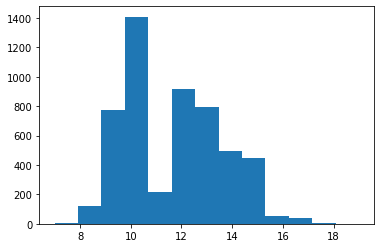

{10: 1976, 9: 1034, 12: 979, 11: 290, 15: 475, 16: 185, 14: 823, 13: 912, 8: 141, 17: 59, 18: 14, 7: 11, 19: 1}


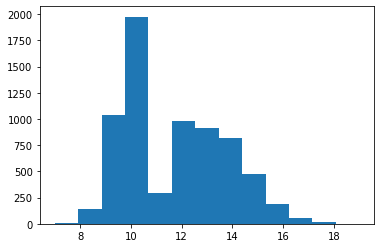

In [70]:
def plot_lengths(log):
    lenghts = [len(x) for x in log]
    s = {}
    for e in lenghts:
        s[e] = lenghts.count(e)
    print(s)
    plt.hist(lenghts, len(set(lenghts)))
    plt.show()
plot_lengths(filtered_log_before)
plot_lengths(filtered_log_after)

In [71]:
def plot_negative_positive(log):
    outcome = ["positive" if "positive" in [i['concept:name'] for i in trace] else "negative" for trace in log]
    print(Counter(outcome))
plot_negative_positive(filtered_log_before)
plot_negative_positive(filtered_log_after)

Counter({'negative': 2661, 'positive': 2608})
Counter({'negative': 3610, 'positive': 3290})


In [72]:
REMOVE_THRESHOLD = 0

def ms(trace):
    multiset = {}
    for pos in trace:
        if pos['concept:name'] not in multiset:
            multiset[pos['concept:name']] = 1
        else:
            multiset[pos['concept:name']] += 1
    return json.dumps(multiset, sort_keys=True).encode()

def hist(trace): 
    hist = str(trace[0]['concept:name'])
    for pos in trace[1:]:
        hist += " - " + str(pos['concept:name'])
    return hist

def transition_system(log, threshold = 0, history = 1, actors = {}):
    edges = []
    edge_counter = {}
    controll = {}
    action = {}
    edge_mapping = {}
    for trace_index in range(len(log)):
        trace = log[trace_index]
        s = "start"
        assert(trace[0]['concept:name']=="start")
        for pos_index in range(1,len(trace)):
            pos = trace[pos_index]
            activity = pos['concept:name']
            controllable = True
            for key in actors:
                if key in activity:
                    controllable = actors[key]=='company'
            #t = ms(trace[max(0,pos_index-history+1):pos_index+1])
            t = hist(trace[max(0,pos_index-history+1):pos_index+1])
            e = (s,t)
            controll[e] = controllable
            action[e] = activity
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
                edge_mapping[e] = [trace_index]
            else:
                edge_counter[e] = edge_counter[e]+1
                edge_mapping[e].append(trace_index)
            s = t
    g = nx.DiGraph()
    for e in edges:
        g.add_edge(e[0], e[1])
    to_remove = []
    trace_index_to_remove = []
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        if edge_counter[e] <= threshold:
            for trace_index in edge_mapping[e]:
                trace_index_to_remove.append(trace_index)
        g[e[0]][e[1]]['controllable'] = controll[e]
        g[e[0]][e[1]]['action'] = action[e]
        if not controll[e]:
            g[e[0]][e[1]]['prob_weight'] = len(edge_mapping[e])

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
    print("numer of removed index", len(trace_index_to_remove))
    
    log_reduced = copy.deepcopy(log)
    for index in trace_index_to_remove:
        log_reduced.pop(index)
    
    if threshold>0:
        return transition_system(log_reduced, history = history, actors = actors)
    
    return g, edge_mapping

with open('activities.xml') as f:
    data = f.read()
actors = json.loads(data)

system_before, edge_mapping_before = transition_system(filtered_log_before, REMOVE_THRESHOLD, history = 3, actors = actors)
system_after, edge_mapping_after = transition_system(filtered_log_after, REMOVE_THRESHOLD, history = 3, actors = actors)

numer of removed index 0
numer of removed index 0


In [73]:
# compute weights
def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i]['concept:name'] == s and trace[i+1]['concept:name'] == t:
            return True
    return False

def weight(trace):
    return 1 if any("positive" in pos['concept:name'] for pos in trace) else -1

def entropy(p1, p2):
    if p1 == 0 or p2 == 0:
        return 0
    return - p1*np.log2(p1) - p2* np.log2(p2)

def distribution(s,t,log, edge_mapping):
    distr = {1.0: 0 , -1.0 : 0}
    assert((s,t) in edge_mapping)
    for trace_index in edge_mapping[(s,t)]:
        w = weight(log[trace_index])
        distr[w] += 1 #
    return distr[1], distr[-1]

def compute_edge_cost(g, traces, edge_mapping):
    #weights = [1 if "finished" in i else -1 for i in traces]
    edge_cost = {}
    counter = 1
    for s in g.nodes:
        counter +=1
        for t in g[s]:
            #if s == "start" or s == "fin" or t == "start" or t == "fin":
                #continue
            #print("s:", s, "t:",t)
            
            p1, p2 = distribution(s,t,traces, edge_mapping)
            w = 1 if p1 >= p2 else -1
            #print("distribution", p1, p2)
            wp1 = p1/(p1+p2)
            wp2 = p2/(p1+p2)
            #w = majority(s,t,traces)
            scaling = 10
            entro = entropy(wp1, wp2)
            #print("entropy",wp1, wp2,entro)
            edge_cost[(s,t)] = (((1-entro) * w) -0.21 )*20
            #print(edge_cost[(s,t)])
    return edge_cost

edge_cost_before = compute_edge_cost(system_before, filtered_log_before, edge_mapping_before)
edge_cost_after = compute_edge_cost(system_after, filtered_log_after, edge_mapping_after)

In [74]:
def draw_dfg(g, name, layout = "sfdp"):
    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
                edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)
    
def annotate_graph(g, edge_cost):
    for e in edge_cost:
        g[e[0]][e[1]]['label'] = round(edge_cost[e],2)
    return g

def color_graph(g, green = 4, red = -4):
    g = copy.deepcopy(g)
    for e in g.edges:
        if g[e[0]][e[1]]['label'] > green:
            g[e[0]][e[1]]['color'] ="green"
        elif g[e[0]][e[1]]['label'] < red:
            g[e[0]][e[1]]['color'] ="red"
        else:
            g[e[0]][e[1]]['color'] ="gray"
    
    return g

g_before = annotate_graph(system_before, edge_cost_before)
g_before_colored = color_graph(g_before)
draw_dfg(g_before, "graph_weight_before.ps", "dot")
draw_dfg(g_before_colored, 'colored_before.ps', "dot")

g_after = annotate_graph(system_after, edge_cost_after)
g_after_colored = color_graph(g_after)
draw_dfg(g_after, "graph_weight_after.ps", "dot")
draw_dfg(g_after_colored, 'colored_after.ps', "dot")

Plotted graph_weight_before.ps
Plotted colored_before.ps
Plotted graph_weight_after.ps
Plotted colored_after.ps


/tmp/ipykernel_7035/3985757443.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traces = np.array(traces)


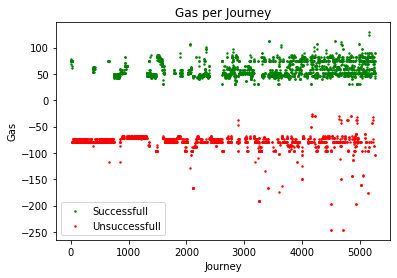

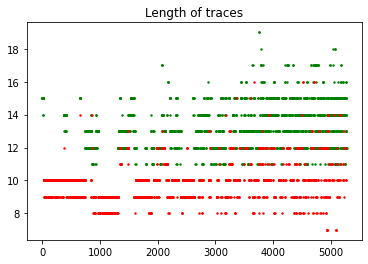

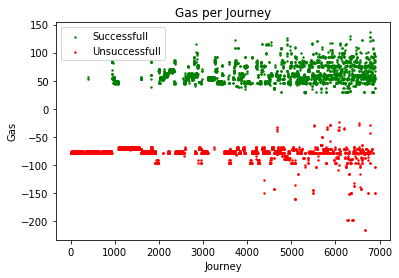

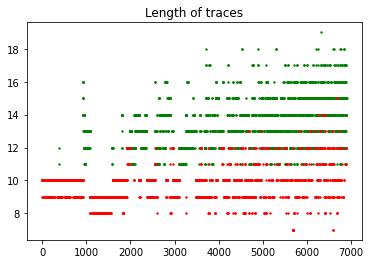

In [75]:
def replay(g, trace, debug = False):
    count = 0
    s = "start"
    for pos_index in range(1,len(trace)):
        action = trace[pos_index]['concept:name']
        t = -1
        for n in g[s]:
            if g[s][n]['action'] == action:
                t = n
        if (s,t) not in g.edges:
            continue
        if debug:
            print(g[s][t]['label'])
        count += g[s][t]['label']
        s = t
    return count

def replay_traces(traces, g, name, debug = False):
    weights = np.array([weight(trace) for trace in traces])
    results = np.array([replay(g,trace) for trace in traces])
    labels = np.array(["true" if w == 1 else "false" for w in weights])
    if debug:
        for i in range(len(results)):
            print("State", weights[i], "has result: ",results[i])
    traces = np.array(traces)
    if debug:
        print(np.array(weights) == 1)
    m = weights == 1

    plt.scatter(np.array(range(len(results)))[m],results[m],c = "g", label="Successfull", s = 2)
    plt.scatter(np.array(range(len(results)))[~m],results[~m],c = "r", label="Unsuccessfull", s = 2)
    plt.title("Gas per Journey")
    plt.xlabel("Journey")
    plt.ylabel("Gas")
    plt.legend()
    #plt.xticks(np.arange(0,len(results),5))
    plt.savefig(name)
    plt.show()

    traces_length = np.array([len(i) for i in traces])
    plt.scatter(np.array(range(len(results)))[m],traces_length[m],c = "g", label="Successfull", s = 2)
    plt.scatter(np.array(range(len(results)))[~m],traces_length[~m],c = "r", label="Unsuccessfull", s = 2)
    plt.title("Length of traces")
    plt.show()

replay_traces(filtered_log_before, g_before, "traces_train_before.png", debug = False)
replay_traces(filtered_log_after, g_after, "traces_train_after.png", debug = False)

In [76]:
def print_cycles(g):
    for c in nx.simple_cycles(g):
        count = 0
        c.append(c[0])
        for i in range(len(c)-1):
            count += g[c[i]][c[i+1]]['label']
        print(len(c))
        print("count", count)
print_cycles(g_before)
print("########")
print_cycles(g_after)

10
count -177.79999999999998
5
count -96.8
10
count -177.79999999999998
6
count -110.13000000000001
5
count 63.2
########
5
count -96.8
5
count 63.2
3
count 31.6


In [77]:
def compute_bounds(g, start, depth):
    lower_bounds = {}
    upper_bounds = {}
    queue = [(start,0)]
    counter = 0
    while(queue and counter < depth):
        counter += 1
        s, previous_gas = queue.pop(0)
        for t in g[s]:
            current_gas = previous_gas + g[s][t]['label']
            if t not in lower_bounds:
                lower_bounds[t] = current_gas
            else:
                lower_bounds[t] = min(lower_bounds[t], current_gas)
            if t not in upper_bounds:
                upper_bounds[t] = current_gas
            else:
                upper_bounds[t] = max(upper_bounds[t], current_gas)
            queue.append((t, current_gas))
    return lower_bounds, upper_bounds
lower_bounds_before, upper_bounds_before = compute_bounds(g_before_colored, "start", 200)
lower_bounds_after, upper_bounds_after = compute_bounds(g_after_colored, "start", 200)

O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT
short -30.380000000000003
long -30.39
very -32.34

O_Create Offer 0 - O_Sent (online only) - W_Call after offers SHORT
short -55.41
long -55.41

O_Sent (mail and online) - W_Call after offers SHORT - A_Validating
short -103.00000000000001
long -30.06
very -16.540000000000003

O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER
short -143.0
long -80.26
very -56.540000000000006

O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 1
short -34.6
long -34.89

O_Sent (mail and online) - W_Call after offers SHORT - O_Cancelled
short -143.0
long -70.06

O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT
short -118.80000000000001
long -63.03

O_Sent (online only) - W_Call after offers SHORT - A_Cancelled CUSTOMER
short -79.61
long -79.61

A_Validating - O_Returned - W_Call incomplete files SHORT
short 5.4399999999999995
long 2.049999999999999
very 13.84999999999

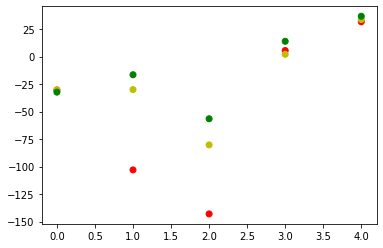

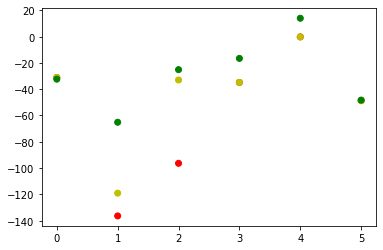

In [78]:
def call_responses(lower_bounds, upper_bounds):
    responses_lower = []
    responses_upper = []
    states = []
    for short in lower_bounds:
        if "SHORT" in short.split("-")[-1] or "SHORT" in short.split("-")[-2]:
            print(short)
            current_lower = []
            current_upper = []
            long = short.replace("SHORT", "LONG")
            very = short.replace("SHORT", "SUPER LONG")
            if short in lower_bounds:
                print("short", lower_bounds[short])
                current_lower.append(lower_bounds[short])
                current_upper.append(upper_bounds[short])
            else:
                current_lower.append(0)
                current_upper.append(0)
            if long in lower_bounds:
                print("long", lower_bounds[long])
                current_lower.append(lower_bounds[long])
                current_upper.append(upper_bounds[long])
            else:
                current_lower.append(0)
                current_upper.append(0)
            if very in lower_bounds:
                print("very", lower_bounds[very])
                current_lower.append(lower_bounds[very])
                current_upper.append(upper_bounds[very])
            else:
                current_lower.append(0)
                current_upper.append(0)
            if current_lower.count(0)==0:
                states.append(short)
                responses_lower.append(current_lower)
                responses_upper.append(current_upper)
            print("")
    print(states)
    print(len(states))
    return responses_lower, responses_upper

def plot_bounds(lower):
    for i in range(len(lower)):
        plt.scatter([i for j in lower[i]],lower[i], c=["r", "y", "g"])
    plt.show()

call_lower_before, call_upper_before = call_responses(lower_bounds_before, upper_bounds_before)
print("######")
call_lower_after, call_upper_after = call_responses(lower_bounds_after, upper_bounds_after)

plot_bounds(call_lower_before)
plot_bounds(call_lower_after)

In [79]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True
    
# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        if debug:
            print(len(G_gen.nodes), len(queue))
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split(".")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "." not in t:
                            t += ".1"
                        else:
                            t = t.split(".")[0]+"."+str(int(t.split(".")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G[s_original][t_original]):
                    G_gen[s][t]['controllable'] = G[s_original][t_original]['controllable']
                if('prob_weight' in G[s_original][t_original]):
                    G_gen[s][t]['prob_weight'] = G[s_original][t_original]['prob_weight']

    print("Graph was unrolled")
    return G_gen

In [80]:
#target = [s for s in g_before_colored.nodes if "positive" in s or "negative" in s]
#g_before_unroll = unroll(g_before_colored, "start", target, 1)
target = [s for s in g_after_colored.nodes if "positive" in s or "negative" in s]
g_after_unroll = unroll(g_after_colored, "start", target, 1)

Graph was unrolled


In [81]:
def final_sound(g):
    # positive final states (should be one)
    positives = []
    for s in g.nodes:
        if "positive" in s:
            positives.append(s)
            print(s)
    assert(len(positives) == 1)
    
final_sound(g_before_unroll)
final_sound(g_after_unroll)

O_Accepted - A_Pending - positive
O_Accepted - A_Pending - positive


In [82]:
out_of_gas = False
def to_uppaal(g, name, layout = "sfdp"):
    f = open("/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/"+name, "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog=layout, args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int e = 0;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('\n'+'bool negative = false;')
    f.write('\n'+'bool positive = false;')
    f.write('\n'+'int final_gas = -1;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    branch = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
        f.write('\n')

    i = max(ids.values())+1
    
    for s in pos:
        for e in g.edges(s):
            if "controllable" in g[e[0]][e[1]]:
                if not g[e[0]][e[1]]["controllable"]:
                    f.write('<branchpoint id="id'+str(i)+'" x="'+str(int(pos[s][0])+20)+'" y="'+str(int(pos[s][1])+20)+'"/>')
                    f.write("\n")
                    branch[s]=i
                    i+=1
                    break # print branchpoint only once per state
                    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    
    for s in pos:
        for e in g.edges(s):
            if "controllable" in g[e[0]][e[1]]:
                if not g[e[0]][e[1]]["controllable"]:
                    f.write('<transition id="'+str(i)+'" controllable="false" >')
                    i = i+1
                    f.write('<source ref="id'+str(ids[s])+'"/>')
                    f.write('<target ref="id'+str(branch[s])+'"/>')
                    f.write('<label kind="assignment" x="'+str(int(pos[s][0]))+'" y="'+str(int(pos[s][1]))+'">')
                    f.write(' steps += 1')
                    f.write(',\n'+ 'x = 0')
                    f.write('</label>')
                    #f.write('<label kind="guard" x="'+str(int(pos[s][0]))+'" y="'+str(int(pos[s][0]))+'"> x&gt;= 1')
                    #f.write('</label>')
                    f.write('</transition>')
                    f.write("\n")
                    break # print branchpoint-edge only once per state
    
    max_id = max(ids.values())
    ids["outOfGas"] = max_id+1
    
    if out_of_gas:
        print_location(f,"id"+str(ids["outOfGas"]),-100,-100,"outOfGas")
    
    for e in g.edges:
        if "label" in g[e[0]][e[1]] and "controllable" in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]["controllable"]:
                print_edge(f, branch[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)
            else:
                print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)
        else:
            if "label" not in g[e[0]][e[1]]:
                if "controllable" not in g[e[0]][e[1]]:
                    print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], 0, True, e, g)

    if out_of_gas:
        for s in g.nodes:
            print(s)
            if "positive" in str(s) or "negative" in str(s):
                continue
            print(ids[s], ids["outOfGas"])
            print_edge(f, ids[s], ids["outOfGas"], pos[s], (-100,-100), 0,True, (s,"outOfGas"), g, guard = False)
    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    print("all written to", f.name)

def print_location(f, location_id, x, y, name):
    name = str(name)
    name = name.replace('"', '-')
    name = name.replace('{', '')
    name = name.replace('}', '')
    name = name.replace("'", '-')
    name = name.replace("_", '')
    name = name.replace("(", '')
    name = name.replace(")", '')
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y)+20)+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y)-30)+'">')
    if "positive" not in name and "negative" not in name and "outOfGas" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t, w, controllable, e, g, guard = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
    
    if controllable and False:
        f.write('<label kind="guard" x="'+str(int(x))+'" y="'+str(int(y))+'"> x&gt;= 1')
        f.write('</label>')
        
    if out_of_gas:
        if guard:
            f.write('<label kind="guard" x="'+str(int(x))+'" y="'+str(int(y))+'"> e&gt;= 0')
            f.write('</label>')
        else:
            f.write('<label kind="guard" x="'+str(int(x))+'" y="'+str(int(y))+'"> e&lt; 0')
            f.write('</label>')
        
    #f.write(',\n'+ 'x = 0')
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write(' steps += 1')
    f.write(',\n'+ 'x = 0')
    if "positive" in str(e[1]):
        f.write(',\n'+ 'positive = true')
        f.write(',\n'+ 'final_gas = e +'+str(int(round(w))))
    elif "negative" in str(e[1]):
        f.write(',\n'+ 'negative = true')
        f.write(',\n'+ 'final_gas = e + '+str(int(round(w))))
        
    f.write(',\n'+'e = e + '+str(int(round(w))))
    f.write('</label>')
    
    if not controllable:
        f.write('<label kind="probability" x="'+str(int(x)-20)+'" y="'+str(int(y)-20)+'">'+str(int(g[e[0]][e[1]]['prob_weight'])))
        f.write('</label>')
    f.write('</transition>')

to_uppaal(g_before_colored, "bpi2017_before.xml", layout = "dot")
to_uppaal(g_before_unroll, "bpi2017_before_unroll.xml")

to_uppaal(g_after_colored, "bpi2017_after.xml", layout = "dot")
to_uppaal(g_after_unroll, "bpi2017_after_unroll.xml")

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017_before.xml
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017_before_unroll.xml
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017_after.xml
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017_after_unroll.xml


In [83]:
def remove_undecision(g):
    g = copy.deepcopy(g)
    for s in g:
        uncontrollable = False
        controllable = False
        for e in g.edges(s):
            print(e)
            attr = g[e[0]][e[1]]
            if attr["controllable"]:
                controllable = True
            else:
                uncontrollable = True
        to_remove = []
        if controllable and uncontrollable:
            for e in g.edges(s):
                attr = g[e[0]][e[1]]
                if attr["controllable"]:
                    to_remove.append(e)
        for e in to_remove:
            g.remove_edge(e[0],e[1])
    return g
#g_decideable = remove_undecision(g)
#draw_dfg(g_decideable, 'decideable.ps', "dot")
#to_uppaal(g_decideable, "decideable.xml")

def query(g):
    # partial graph implications, per activity
    results = {}
    intervals = {}
    min_gas = {}
    #print(len(set([x['concept:name'] for trace in filtered_log for x in trace])))
    counter = 0
    for a in g.nodes:
        print("counter", counter, "current action", a)
        counter += 1
        states = [a]

        sub_nodes = set()
        for s in states:
            sub_nodes.update(set(list(nx.descendants(g, s))))
            sub_nodes.add(s)
        if len(sub_nodes) > 90:
            continue
        subgraph = nx.subgraph(g, sub_nodes)
        subgraph = nx.DiGraph(subgraph)

        # add start node to subgraph
        start_nodes = []
        for n in subgraph.nodes:
            if subgraph.in_degree(n) == 0:
                start_nodes.append(n)
        for n in start_nodes:
            subgraph.add_edge("start", n)
            subgraph["start"][n]["controllable"] = True
            subgraph["start"][n]["label"] = 0
        # if initial node lies on cycle, per default set as start node
        if "start" not in subgraph.nodes:
            for n in states:
                subgraph.add_edge("start", n)
                subgraph["start"][n]["controllable"] = True
                subgraph["start"][n]["label"] = 0

        target = [s for s in subgraph.nodes if "positive" in s or "negative" in s]
        subgraph_unrolled = unroll(subgraph, "start", target, 1)
        positives = []
        for s in subgraph_unrolled.nodes:
            if "positive" in s:
                positives.append(s)
        assert(len(positives) <= 1)
        to_uppaal(subgraph_unrolled, "bpi2017subgraph.xml")
        out = subprocess.Popen(["/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/queries/guaranteed.q"], stdout=subprocess.PIPE)
        result = "is satisfied" in str(out.communicate()[0])
        print("result", result)
        results[a] = result

        decideable = remove_undecision(subgraph)
        target = [s for s in decideable.nodes if "positive" in s or "negative" in s]
        decideable_unrolled = unroll(decideable, "start", target, 1)
        positives = []
        for s in decideable_unrolled.nodes:
            if "positive" in s:
                positives.append(s)
        assert(len(positives) <= 1)
        to_uppaal(decideable_unrolled, "bpi2017subgraph.xml")
        out = subprocess.Popen(["/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/queries/probability.q", "-E", "0.001"], stdout=subprocess.PIPE)
        s = str(out.communicate()[0]).split("formula 3")[1].split("Pr(<>")[1]
        interval = s[s.find("["):s.find("]")+1]
        print("interval", interval)
        intervals[a] = interval

        out = subprocess.Popen(["/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/queries/min_gas.q"], stdout=subprocess.PIPE)
        s = str(out.communicate()[0]).split("formula 3")[1].split("Values in")[1]
        interval = s[s.find("["):s.find("]")+1]
        print("min gas", interval)
        min_gas[a] = interval
        
    return results, intervals, min_gas

#results_before, intervals_before, min_gas_before = query(g_before_colored)
results_after, intervals_after, min_gas_after = query(g_after_colored)

counter 0 current action start
counter 1 current action start - A_Create Application
counter 2 current action start - A_Create Application - A_Submitted
counter 3 current action A_Create Application - A_Submitted - A_Concept
counter 4 current action A_Submitted - A_Concept - A_Accepted
counter 5 current action A_Concept - A_Accepted - O_Create Offer 0
counter 6 current action A_Accepted - O_Create Offer 0 - O_Sent (mail and online)
counter 7 current action O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CU

min gas [-72,-48]
counter 8 current action O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 9 current action W_Call after offers SHORT - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('start', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017sub

min gas [-48,-48]
counter 13 current action O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER', 'W_Call after offers LONG - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 14 current action W_Call after offers LONG - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('start', 'W_Call after offers LONG - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgrap

interval [0.073846,0.0758369]
min gas [-14,0]
counter 18 current action W_Call after offers SHORT - A_Validating - O_Returned
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A

interval [0.999,1]
min gas [0,0]
counter 22 current action O_Create Offer 0 - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incom

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-36,-34]
counter 24 current action O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('O_Sent (mail 

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-48,-48]
counter 25 current action W_Call after offers SHORT - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('O_Sent (mail 

min gas [-76,-48]
counter 26 current action O_Create Offer 1 - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHO

interval [0,0.000999738]
min gas [-48,-48]
counter 28 current action O_Returned - W_Call incomplete files SHORT - O_Accepted
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result True
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - O_Accepted', 'W_Call incomplete files SHORT - O_Accepted - A_Pending')
('start', 'O_Returned - W_Call incomplete files SHORT - O_Accepted')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 29 current action W_Call incomplete files SHORT - O_Accepted - A_Pending
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result True
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'W_Call incomplete files

interval [0.999,1]
min gas [0,0]
counter 34 current action W_Call incomplete files SHORT - A_Validating - O_Accepted
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result True
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('start', 'W_Call incomplete files SHORT - A_Validating - O_Accepted')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 35 current action A_Validating - O_Accepted - A_Pending
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result True
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'A_Validating - O_Accepted - A_Pending')
Graph was unrolled
all written to /home/paul/Downloads/

interval [0.999,1]
min gas [0,0]
counter 39 current action W_Call incomplete files LONG - A_Validating - O_Accepted
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result True
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 40 current action O_Sent (mail and online) - W_Call after offers LONG - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomple

min gas [-6,-6]
counter 41 current action W_Call after offers LONG - A_Validating - O_Returned
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete

interval [0,0.000999738]
min gas [-48,-48]
counter 43 current action O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Cancelled CUSTOMER', 'W_Call after offers SUPER LONG - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 44 current action W_Call after offers SUPER LONG - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('start', 'W_Call after offers SUPER LONG - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/p

interval [0,0.000999738]
min gas [-48,-32]
counter 47 current action A_Accepted - O_Create Offer 0 - O_Create Offer 1
counter 48 current action O_Create Offer 0 - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER', 'W_Call after offers LONG - A_Cancelled CUSTOMER - negative')
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - W_Call incomplete files SHORT')
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validati

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-103,-48]
counter 49 current action O_Create Offer 1 - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned -

interval [0,0.000999738]
min gas [-54,-48]
counter 50 current action O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call inco

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-48,-48]
counter 51 current action O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 52 current action O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Valid

min gas [-48,-48]
counter 53 current action O_Sent (mail and online) - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete f

interval [0,0.000999738]
min gas [-96,-48]
counter 56 current action O_Sent (mail and online) - W_Call after offers LONG - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete f

interval [0,0.000999738]
min gas [-48,-48]
counter 58 current action W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result True
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - W_Call incomplete files LONG - A_Vali

interval [0.999,1]
min gas [0,0]
counter 62 current action A_Validating - W_Call incomplete files SHORT - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result True
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete

interval [0.999,1]
min gas [0,0]
counter 68 current action O_Create Offer 0 - O_Sent (mail and online) - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('O_Se

result False
('O_Create Offer 1 - O_Sent (online only) - A_Validating', 'O_Sent (online only) - A_Validating - O_Returned')
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('O_Create Offer 1 - O_Sent (online only) - A_Cancelled CUSTOMER', 'O_Sent (online only) - A_Cancelled CUSTOMER - negative')
('O_Sent (online only) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only)', 'O_Create Offer 1 - O_Sent (online only) - A_Cancelled CUSTOMER')
('O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only)', 'O_Create Offer 1 - O_Sent (online only) - A_Validating')
('O_Returned - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only)')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-48,-48]


all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-52,-52]
counter 75 current action O_Create Offer 0 - O_Sent (online only) - W_Call after offers SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call inco

interval [0,0.000999738]
min gas [-24,-24]
counter 77 current action O_Create Offer 0 - O_Sent (online only) - W_Call after offers LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files 

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('O_Returned - A_Validating

interval [0,0.000999738]
min gas [-96,-72]
counter 82 current action O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Cancelled - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER', 'W_Call after offers LONG - A_Cancelled CUSTOMER - negative')
('O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - A_Cancelled CUSTOMER')
('O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT')
('O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Se

min gas [-38,-38]
counter 87 current action W_Call incomplete files SHORT - O_Returned - W_Call incomplete files SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplet

interval [0,0.000999738]
min gas [-48,-48]
counter 90 current action O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('start', 'O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 91 current action W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('start', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/b

interval [0.999,1]
min gas [0,0]
counter 96 current action A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER', 'O_Create Offer 0 - A_Cancelled CUSTOMER - negative')
('start', 'A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 97 current action O_Create Offer 0 - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('start', 'O_Create Offer 0 - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 98 current action A_Ac

interval [0,0.000999738]
min gas [-144,-96]
counter 99 current action O_Create Offer 0 - O_Cancelled - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating -

min gas [-120,-72]
counter 100 current action O_Cancelled - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomple

interval [0,0.000999738]
min gas [-96,-48]
counter 101 current action O_Sent (mail and online) - W_Call after offers SHORT - O_Cancelled
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG'

interval [0,0.000999738]
min gas [-72,-48]
counter 102 current action W_Call after offers SHORT - O_Cancelled - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call after offers SHORT - O_Cancelled - A_Cancelled CUSTOMER', 'O_Cancelled - A_Cancelled CUSTOMER - negative')
('start', 'W_Call after offers SHORT - O_Cancelled - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 103 current action O_Cancelled - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('start', 'O_Cancelled - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
cou

interval [0,0.000999738]
min gas [-120,-72]
counter 107 current action O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers SUPER LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Ca

interval [0,0.000999738]
min gas [0,0]
counter 110 current action O_Sent (online only) - W_Call after offers SHORT - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT'

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 113 current action W_Call after offers SHORT - A_Validating - W_Call incomplete files LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result True
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepte

interval [0.999,1]
min gas [0,0]
counter 116 current action O_Sent (mail and online) - A_Validating - W_Call incomplete files SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUST

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 119 current action W_Call after offers SUPER LONG - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 123 current action O_Create Offer 0 - O_Create Offer 1 - O_Create Offer 2
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHO

min gas [-144,-144]
counter 124 current action O_Create Offer 1 - O_Create Offer 2 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_

min gas [-120,-120]
counter 125 current action O_Create Offer 2 - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validat

min gas [-96,-96]
counter 126 current action O_Sent (mail and online) - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_V

min gas [-72,-72]
counter 127 current action O_Create Offer 1 - O_Sent (mail and online) - O_Create Offer 2
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete file

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-48,-48]
counter 129 current action O_Create Offer 2 - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Sent (mail and online) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted'

interval [0,0.000999738]
min gas [-96,-96]
counter 132 current action O_Cancelled - O_Cancelled - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER')
('O_Cancelled - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT')
('start', 'O_Cancelled - O_Cancelled - O_Sent (mail and online)')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-72,-72]
counter 133 current action O_Sent (mail and online) - O_Sent (mail and online) - O_Create Offer 2
Graph was unrolled
al

interval [0,0.000999738]
min gas [-24,-24]
counter 135 current action O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 2
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Create Offer 2 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 2', 'W_Call after offers SHORT - O_Create Offer 2 - O_Sent (mail and online)')
('W_Call after offers SHORT - O_Create Offer 2 - O_Sent (mail and online)', 'O_Create Offer 2 - O_Sent (mail and online) - A_Cancelled CUSTOMER')
('start', 'O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 2')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-72,-72]
counter 136 current action W_Call after offers SHORT - O_Create Offer 2

min gas [-19,-16]
counter 138 current action O_Sent (mail and online) - O_Create Offer 1 - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('O_Sent (mail and online) - O_Create Offer 1 - A_Cancelled CUSTOMER', 'O_Create Offer 1 - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - O_Create Offer 1 - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 139 current action W_Call after offers SHORT - O_Cancelled - W_Call after offers SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call after offers SHORT - O_Cancelled - W_Call after offers SHORT', 'O_Cancelled - W_Call after offers SHORT - A_Cancelled CUSTOMER')
('O_Cancelled - W_Call after offers SHORT - A_Cancelled C

interval [0,0.000999738]
min gas [-144,-144]
counter 145 current action O_Create Offer 2 - O_Create Offer 3 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files S

min gas [-120,-120]
counter 146 current action O_Create Offer 3 - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
result False
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG', 'A_Validating - W_Call incomplete files LONG - O_Accepted')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('O_Returned - A_Validating - W_Call incomplete files SHORT', 'A_Validat

min gas [-96,-96]


In [84]:
events_before = set([x['concept:name'] for trace in filtered_log_before for x in trace])
events_after = set([x['concept:name'] for trace in filtered_log_after for x in trace])
events = events_before.union(events_after)

events_short = {}
for e in events:
    numbers = [int(s) for s in e.split(" ") if s.isdigit()]
    if not numbers:
        events_short[e] = e[:3]
    else:
        assert(len(numbers)==1)
        events_short[e] = e[:3]+str(numbers[0])
    if "online only" in e:
        events_short[e] += ".o"
    if "mail and online" in e:
        events_short[e] += ".m+o"
    if "SHORT" in e:
        events_short[e] += ".s"
    if "SUPER LONG" in e:
        events_short[e] += ".sl"
    elif "LONG" in e:
        events_short[e] += ".s"
    print(e, events_short[e])
print(len(events_short), set([e for e in events_short[e]]))
print(events)
print(len(events_before), len(events_after))

A_Concept A_C
O_Create Offer 2 O_C2
W_Call incomplete files SUPER LONG W_C.sl
A_Create Application A_C
A_Validating A_V
A_Pending A_P
W_Call after offers SHORT W_C.s
O_Create Offer 1 O_C1
O_Cancelled O_C
O_Create Offer 3 O_C3
W_Call incomplete files LONG W_C.s
O_Create Offer 0 O_C0
negative neg
O_Sent (mail and online) O_S.m+o
O_Returned O_R
O_Sent (online only) O_S.o
A_Accepted A_A
W_Call after offers SUPER LONG W_C.sl
W_Call incomplete files SHORT W_C.s
A_Submitted A_S
A_Cancelled CUSTOMER A_C
start sta
W_Call after offers LONG W_C.s
O_Accepted O_A
positive pos
25 {'s', 'o', 'p'}
{'A_Concept', 'O_Create Offer 2', 'W_Call incomplete files SUPER LONG', 'A_Create Application', 'A_Validating', 'A_Pending', 'W_Call after offers SHORT', 'O_Create Offer 1', 'O_Cancelled', 'O_Create Offer 3', 'W_Call incomplete files LONG', 'O_Create Offer 0', 'negative', 'O_Sent (mail and online)', 'O_Returned', 'O_Sent (online only)', 'A_Accepted', 'W_Call after offers SUPER LONG', 'W_Call incomplete files

In [91]:
def draw_dfg(g, name, results, intervals, layout = "sfdp"):
    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))
    g = copy.deepcopy(g)

    for s in results:
        pos = False
        neg = False
        if s not in g:
            continue
        for n in g[s]:
            if n in results:
                if results[n]:
                    pos = True
                else:
                    neg = True
            if "pos" in n:
                pos = True
            if "neg" in n:
                neg = True
        if not pos and not neg:
            continue
        if pos and neg:
            g.nodes[s]['color'] = "blue"
        else:
            #n = g.get_node(s)
            #n.attr['fillcolor']="#CCCCFF"
            g.nodes[s]['color'] = "grey"
            #g.node[s]['color']="grey"
        if intervals[s] not in ["[0,0.000999738]", "[0.999,1]"]:
            pass # probabilities not included
            #g.nodes[s]['shape'] = "doublecircle"
    
    for e in g.edges:
        if "Cancelled COMPANY" in g[e[0]][e[1]]['action']:
            g[e[0]][e[1]]['color'] = "violet"
            #g[e[0]][e[1]]['style'] = "dashed"
    
    edges = nx.bfs_edges(g, "start")
    nodes = ["start"] + [v for u, v in edges]

    new_labels = {}
    for n,i in zip(nodes, range(len(nodes))):
        h = [e.strip() for e in n.split("-")]
        h1 = events_short[h[0]]
        for e in h[1:]:
            h1 += " - "
            h1 += events_short[e]
        new_labels[n] = h1
    
    new_labels.pop("start")
    new_labels.pop("positive")
    new_labels.pop("negative")
    
    g = nx.relabel_nodes(g, new_labels)
    #g = nx.convert_node_labels_to_integers(g)
    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        edge = A.get_edge(e[0], e[1])
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge.attr["style"] = "dotted"
        edge.attr["label"] = ""
                #edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)
    for n in A:
        if n not in intervals:
            continue
        if intervals[n] not in ["[0,0.000999738]", "[0.999,1]"]:
            print(n)
        print(str(new_labels[n]))
        #print("bound", str(lower_bounds[n]))
        #n.attr['label'] = str(min_gas[n])
    
    #A.graph_attr.update(size="7.75,10.25")
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)
    
def reachable_cluster(g, results, intervals, name):
    pos_cluster = []
    neg_cluster = []
    g = copy.deepcopy(g)
    to_remove = []
    for s in g:
        subgraph = nx.subgraph(g, set(list(nx.descendants(g, s))))
        subgraph = nx.DiGraph(subgraph)
        nodes = [s for s in subgraph]
        sub_results = [results[n] for n in results if n in nodes]
        if len(set(sub_results))<2:
            if results[s]:
                pos_cluster.append(s)
            else:
                neg_cluster.append(s)

    for s in pos_cluster:
        g = nx.contracted_nodes(g, "positive", s)
    for s in neg_cluster:
        if "TIM" in s.split("-")[-1]:
            print("skipped")
            continue
        g = nx.contracted_nodes(g, "negative", s)
        
    g.remove_edges_from(nx.selfloop_edges(g))
    
    g = merge_connections(g)
    
    draw_dfg(g, name, results, intervals, layout = "dot")

    
def get_connection(g):
    for s in g:
        if len(list(g[s]))!= 1:
            continue
        assert(len(list(g[s]))==1)
        v = list(g[s])[0]

        edges = list(g.in_edges(v))
        if len(edges) == 1:
            s1 = edges[0][0]
            v1 = edges[0][1]
            assert(s == s1 and v == v1)
            return (s,v)
    return None

def merge_connections(g):
    g = copy.deepcopy(g)
    
    edge = get_connection(g)
    while(edge != None):
        g = nx.contracted_nodes(g, edge[0], edge[1])
        g.remove_edges_from(nx.selfloop_edges(g))
        edge = get_connection(g)
        
    return g

#reachable_cluster(g_before_colored, results_before, intervals_before, 'clustered_before.png')
reachable_cluster(g_after_colored, results_after, intervals_after, 'clustered_after.png')

Plotted clustered_after.png


In [87]:
def investigate_calls(log):
    for element in ["W_Call after offers", "W_Call incomplete files"]:
        # claim: calls are not really helpful...
        outcomes_call = {"pos": 0, "neg": 0}
        outcomes_no_call = {"pos": 0, "neg": 0}
        outcomes_short = {"pos": 0, "neg": 0}
        outcomes_long = {"pos": 0, "neg": 0}
        outcomes_super = {"pos": 0, "neg": 0}
        for trace in log:
            call = [element in pos["concept:name"] for pos in trace]
            short = [element+" SHORT" in pos["concept:name"] for pos in trace]
            long = [element+" LONG" in pos["concept:name"] for pos in trace]
            super_long = [element+" SUPER LONG" in pos["concept:name"] for pos in trace]
            result = ["positive" in pos["concept:name"] for pos in trace]
            if sum(call) > 0:
                if sum(result) > 0:
                    outcomes_call["pos"] += 1
                    if sum(short) > 0:
                        outcomes_short["pos"] += 1
                    elif sum(long) > 0:
                        outcomes_long["pos"] += 1
                    elif sum(super_long) > 0:
                         outcomes_super["pos"] += 1
                else:
                    outcomes_call["neg"] += 1
                    if sum(short) > 0:
                        outcomes_short["neg"] += 1
                    elif sum(long) > 0:
                        outcomes_long["neg"] += 1
                    elif sum(super_long) > 0:
                         outcomes_super["neg"] += 1
            else:
                if sum(result) > 0:
                    outcomes_no_call["pos"] += 1
                else:
                    outcomes_no_call["neg"] += 1
        
        print(element)
        print("no call")
        print(outcomes_no_call)
        print(outcomes_no_call["pos"]/(outcomes_no_call["neg"]+outcomes_no_call["pos"]))
        print("call")
        print(outcomes_call)
        print(outcomes_call["pos"]/(outcomes_call["neg"]+outcomes_call["pos"]))
        print("short")
        print(outcomes_short)
        print(outcomes_short["pos"]/(outcomes_short["neg"]+outcomes_short["pos"]))
        print("long")
        print(outcomes_long)
        print(outcomes_long["pos"]/(outcomes_long["neg"]+outcomes_long["pos"]))
        print("super")
        print(outcomes_super)
        print(outcomes_super["pos"]/(outcomes_super["neg"]+outcomes_super["pos"]))
        print()
        # calls not really impact
        # after drift are super long calls 3% more effective (0.34)
    
investigate_calls(filtered_log_before)
print("########")
investigate_calls(filtered_log_after)

W_Call after offers
no call
{'pos': 396, 'neg': 401}
0.4968632371392723
call
{'pos': 2212, 'neg': 2260}
0.49463327370304117
short
{'pos': 2023, 'neg': 2059}
0.4955903968642822
long
{'pos': 182, 'neg': 186}
0.4945652173913043
super
{'pos': 7, 'neg': 15}
0.3181818181818182

W_Call incomplete files
no call
{'pos': 1500, 'neg': 2639}
0.362406378352259
call
{'pos': 1108, 'neg': 22}
0.9805309734513274
short
{'pos': 938, 'neg': 18}
0.9811715481171548
long
{'pos': 169, 'neg': 4}
0.976878612716763
super
{'pos': 1, 'neg': 0}
1.0

########
W_Call after offers
no call
{'pos': 506, 'neg': 538}
0.4846743295019157
call
{'pos': 2784, 'neg': 3072}
0.47540983606557374
short
{'pos': 2580, 'neg': 2840}
0.47601476014760147
long
{'pos': 190, 'neg': 206}
0.4797979797979798
super
{'pos': 14, 'neg': 26}
0.35

W_Call incomplete files
no call
{'pos': 1505, 'neg': 3590}
0.29538763493621195
call
{'pos': 1785, 'neg': 20}
0.9889196675900277
short
{'pos': 1604, 'neg': 16}
0.9901234567901235
long
{'pos': 180, 'neg': 4